In [2]:
! pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.9/836.9 kB 12.5 MB/s eta 0:00:00a 0:00:01


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import math

In [4]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 3)  # Prob of Left

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [5]:
def transformState(S_t):
    return [ math.atan2( S_t[0], S_t[1]), math.atan2( S_t[2], S_t[3]), S_t[4], S_t[5] ]

episode_durations = []
episode_rewards = []
episode_success = []

def main():

    # Parameters
    num_episode = 1000
    batch_size = 5
    learning_rate = 0.01
    gamma = 0.99

    env = gym.make('Acrobot-v1')
    policy_net = PolicyNet()
    policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)

    # Batch History
    state_pool = []
    action_pool = []
    reward_pool = []
    steps = 0


    for e in range(num_episode):

        state = env.reset()[0]
        state = np.array(transformState(state))
        state = torch.from_numpy(state).float()
        state = Variable(state)

        for t in range(1000):

            probs = policy_net(state)
            m = Categorical(probs)
            action = m.sample()

            action = action.data.numpy().astype(int)
            stepData = env.step(action)
            next_state, reward, done, truncated, info = stepData[0], stepData[1], stepData[2], stepData[3], stepData[4]
            next_state = np.array(transformState(next_state))

            # To mark boundarys between episodes
            if done:
                reward = 0

            state_pool.append(state)
            action_pool.append(float(action))
            reward_pool.append(reward)

            state = next_state
            state = torch.from_numpy(state).float()
            state = Variable(state)

            steps += 1

            if done:
                episode_durations.append(t + 1)
                print("Episode:",e,"\tDuration:",t+1)
                episode_rewards.append(-t)

                break

        # Update policy
        if e > 0 and e % batch_size == 0:

            # Discount reward
            return_G = 0
            for i in reversed(range(steps)):
                if reward_pool[i] == 0:
                    return_G = 0
                else:
                    return_G = return_G * gamma + reward_pool[i]
                    reward_pool[i] = return_G

            # print(reward_pool)
            # print(len(reward_pool))

            # Normalize reward
            # reward_mean = np.mean(reward_pool)
            # reward_std = np.std(reward_pool)
            # for i in range(steps):
            #     reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

            # Gradient Desent
            policy_optimizer.zero_grad()

            for i in range(steps):
                state = state_pool[i]
                action = Variable(torch.FloatTensor([action_pool[i]]))
                reward = reward_pool[i]

                probs = policy_net(state)
                m = Categorical(probs)
                loss = -m.log_prob(action) * reward  # Negtive score function x reward
                loss.backward()

            policy_optimizer.step()
            
            
            state_pool = []
            action_pool = []
            reward_pool = []
            steps = 0


if __name__ == '__main__':
    main()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 0 	Duration: 920
Episode: 6 	Duration: 767
Episode: 7 	Duration: 787
Episode: 8 	Duration: 791
Episode: 10 	Duration: 619
Episode: 11 	Duration: 952
Episode: 12 	Duration: 864
Episode: 13 	Duration: 492
Episode: 14 	Duration: 427
Episode: 15 	Duration: 903
Episode: 16 	Duration: 515
Episode: 17 	Duration: 450
Episode: 18 	Duration: 946
Episode: 19 	Duration: 507
Episode: 20 	Duration: 309
Episode: 21 	Duration: 304
Episode: 22 	Duration: 495
Episode: 23 	Duration: 357
Episode: 24 	Duration: 307
Episode: 25 	Duration: 366
Episode: 26 	Duration: 401
Episode: 27 	Duration: 393
Episode: 28 	Duration: 337
Episode: 29 	Duration: 231
Episode: 30 	Duration: 342
Episode: 31 	Duration: 288
Episode: 32 	Duration: 190
Episode: 33 	Duration: 213
Episode: 34 	Duration: 783
Episode: 35 	Duration: 186
Episode: 36 	Duration: 227
Episode: 37 	Duration: 186
Episode: 38 	Duration: 128
Episode: 39 	Duration: 417
Episode: 40 	Duration: 188
Episode: 41 	Duration: 243
Episode: 42 	Duration: 150
Episo

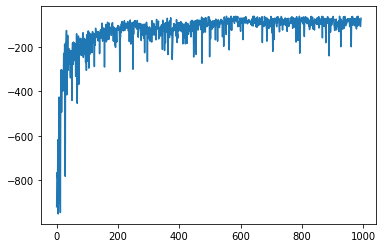

In [12]:
plt.figure()
plt.plot(episode_rewards)
plt.savefig('lr-01.png')
plt.show()

<Figure size 432x288 with 0 Axes>